In [63]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import importlib
import unicodedata
import sys

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from nltk.stem.porter import PorterStemmer

In [64]:
train_data = pd.read_csv('../data/sentiment140_train.zip', encoding='ISO-8859-1', header=None, names=['sentiment','id','timestamp','type','user','text'])
test_data = pd.read_csv('../data/sentiment140_test.zip', encoding='ISO-8859-1', header=None, names=['sentiment','id','timestamp','type','user','text'])

train_data = train_data[['text','sentiment']]
test_data = test_data[['text','sentiment']]

In [68]:
print('train_data:')
print(train_data.dtypes)
print('test_data:')
print(test_data.dtypes)

train_data:
text         object
sentiment     int64
dtype: object
test_data:
text         object
sentiment     int64
dtype: object


In [69]:
print('Positive rows: {}'.format(train_data[ train_data['sentiment'] == 4]['sentiment'].size))
print('Negative rows: {}'.format(train_data[ train_data['sentiment'] == 0]['sentiment'].size))

Positive rows: 800000
Negative rows: 800000


In [70]:
train_data = shuffle(train_data, random_state=40)

In [71]:
def print_df_head(df, limit=50):
    for i, row in enumerate(df.iterrows()):
        print(row[1]['sentiment'], row[1]['text'])
        if i == limit:
            break
            
print_df_head(train_data)

0 I don't want to leave 
4 good nite all! sleep tight don't let the bed bugs bite 
4 It's a beautiful day! Guess who's going to see U2 in concert this fall?  yep - me! B/c @jaredbridges is the most amazing husband ever!!!!
4 yay for ikea swedish meatballs 
0 and God knows how many more SingStar and Buzz iterations announced. Rock Band Unplugged to be awesome, OnLive to be absent.  #e3
4 @rosie_edward Thanks you so much for following me on Twitter; I hope you find it as exciting as I do! Looking forward to your tweets! 
4 good morning all... hope ur day started well 
0 so bored.. weekend is almost over 
4 @carlaloo @jajanika Found our entry! Woohoo! Check them out. I entered 2 pictures.  I hope we win. *crossed fingers*
4 Ooh look who seems to be working tonight... way to go twitter! 
0 getting back to office on a Monday after a totally unscheduled off is so .... err.... Sad 
0 is in Concord, sick at M&amp;D's house while everyone else is at church. 
0 makingg youtubes with myy cousin; 

In [72]:
# Remove twitter @ tags
def remove_twitter_at(text):
    # Get rid of the leading @
    text = re.sub('^@.*? ', '', text)
    
    # Get rid of @ in the middle of the tweet
    text = re.sub(' @.*? ', ' ', text)
    
    # Get rid of tailing @
    text = re.sub(' @.*?$', '', text)
    
    return text
    
train_data['text'] = train_data['text'].apply(remove_twitter_at)
test_data['text'] = test_data['text'].apply(remove_twitter_at)

In [73]:
# Create a table to map punctuations to None
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
        if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuations(text):
    return text.translate(tbl)

train_data['text'] = train_data['text'].apply(remove_punctuations)
test_data['text'] = test_data['text'].apply(remove_punctuations)

In [74]:
# Only remove separate digits, not digits within word, such as `U2`
def remove_digits(text):
    # Remove leading digits
    text = re.sub('^\d+? ', ' ', text)
    
    # Remove other digits
    text = re.sub(' \d+', ' ', text)
    
    return text

train_data['text'] = train_data['text'].apply(remove_digits)
test_data['text'] = test_data['text'].apply(remove_digits)

In [75]:
def to_lowercase(text):
    return text.lower()

train_data['text'] = train_data['text'].apply(to_lowercase)
test_data['text'] = test_data['text'].apply(to_lowercase)

In [76]:
# Split a string to a list of words
def split(text):
    return text.split()

train_data['text'] = train_data['text'].apply(split)
test_data['text'] = test_data['text'].apply(split)

In [77]:
# https://www.quora.com/Is-there-a-stop-word-list-specifically-designed-for-sentiment-analysis
# As stated before, the general nltk stopwords may have a negative impacts on sentiment analysis, as it removes
# negation words such as don't. Here I build a minimal set of stopwords specific to sentiment analysis. 

stopwords = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", 
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and'
]

def remove_stopwords(arr):
    arr = [word for word in arr if word not in stopwords]
    return arr

train_data['text'] = train_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)

In [78]:
stemmer = PorterStemmer()

# Transform word from the derived form to root form when applicable 
def stem_words(arr):
    arr = [stemmer.stem(word) for word in arr]
    return arr

train_data['text'] = train_data['text'].apply(stem_words)
test_data['text'] = test_data['text'].apply(stem_words)

In [79]:
def get_corpus_vocabulary(df):
    vocabulary = Counter()
    for _, row in df.iterrows():
        words = row['text']
        for word in words:
            vocabulary[word] += 1
    return vocabulary

vocabulary = get_corpus_vocabulary(train_data)

The size of the training corpus: 465158
The top 10 words are: [(563975, 'to'), (215064, 'for'), (214112, 'in'), (183254, 'of'), (176921, 'im'), (166902, 'on'), (150638, 'so'), (136967, 'go'), (127416, 'but'), (124973, 'just')]
The least 10 words are: [(1, '$$$down'), (1, '$$$dinerocashbucksgreenbenjaminschangeoth'), (1, '$$$1500'), (1, '$$$+'), (1, '$$$$$they'), (1, '$$$$$$fgdf^amp^^^^'), (1, '$$$$$$$$$$$$$'), (1, '$$$$$$$$$$$$'), (1, '$$$$$$$$$$$'), (1, '$$$$$$$$$')]
[1, 1, 1, 2, 2, 3, 4, 5, 6, 6, 7, 9, 10, 11, 12, 14, 15, 17, 19, 20, 22, 24, 26, 29, 31, 34, 37, 40, 43, 46, 49, 52, 56, 59, 63, 67, 72, 76, 81, 86, 92, 97, 103, 110, 117, 124, 132, 141, 150, 160, 171, 182, 193, 206, 219, 233, 248, 264, 280, 298, 317, 338, 359, 383, 409, 436, 466, 499, 536, 577, 621, 671, 726, 787, 853, 927, 1011, 1105, 1213, 1334, 1472, 1633, 1817, 2033, 2292, 2602, 2978, 3443, 4030, 4788, 5807, 7215, 9346, 12838, 19175, 32595, 66621, 161824, 313491, 465158]


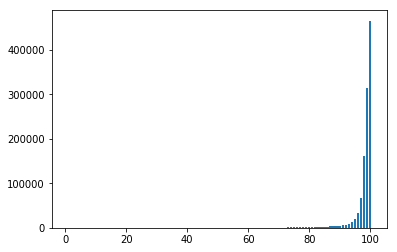

In [90]:
def show_vocabulary_summary(vocabulary):
    corpus_total_cnt = sum(vocabulary.values())
    sorted_by_wd_cnt = sorted(((cnt, wd) for wd, cnt in vocabulary.items()), reverse=True)

    plt_points = []
    accu = 0
    j = 0
    for i in range(1, 101):
        while accu < (corpus_total_cnt * i / 100.0):
            accu += sorted_by_wd_cnt[j][0]
            j += 1
        plt_points.append(j)

    print('The size of the training corpus: {}'.format(len(vocabulary)))
    print('The top 10 words are: {}'.format(sorted_by_wd_cnt[:10]))
    print('The least 10 words are: {}'.format(sorted_by_wd_cnt[-10:]))
    print(plt_points)
    plt.bar(range(1, 101), plt_points)
    
show_vocabulary_summary(vocabulary)

The top 20000 words account for 94% word occurance of the entire corpus.

In [81]:
def join(arr):
    return ' '.join(arr)

train_data['text'] = train_data['text'].apply(join)
test_data['text'] = test_data['text'].apply(join)

In [82]:
print_df_head(train_data)

0 dont want to leav
4 good nite all sleep tight dont let bed bug bite
4 beauti day guess who go to see u2 in concert fall yep bc most amaz husband ever
4 yay for ikea swedish meatbal
0 god know how mani more singstar buzz iter announc rock band unplug to awesom onliv to absent e3
4 thank so much for follow on twitter hope find as excit as look forward to tweet
4 good morn all hope ur day start well
0 so bore weekend almost over
4 jajanika found entri woohoo check out enter pictur hope win cross finger
4 ooh look seem to work tonight way to go twitter
0 get back to offic on monday after total unschedul off so err sad
0 in concord sick at mampd hous while everyon els at church
0 makingg youtub with myy cousin bahaha grrrrr he goingg to vega
4 to may concern whore aint suppos to eat salad damn earli in morn lmmfao
0 so how everyon enjoy new iphon im tad jealou but servic plan still stop
4 happi birthday lovelt3 hope good one
0 sleepi though
0 mornnnninggg ugh by cub gone to work without p

In [84]:
print_df_head(test_data)

4 loooooooovvvvvvee kindle2 not dx cool but fantast in own right
4 read kindle2 love lee child good read
4 ok first asses of kindle2 fuck rock
4 youll love kindle2 ive mine for few month never look back new big one huge no need for remors
4 fair enough but kindle2 think perfect
4 no too big im quit happi with kindle2
0 fuck economi hate aig non loan given ass
4 jqueri new best friend
4 love twitter
4 how can not love obama make joke about
0 firmli believ obamapelosi zero desir to civil charad slogan but want to destroy conservat
4 hous correspond dinner last night whoopi barbara amp sherri went obama got stand ovat
4 watchin espnju seen new nike commer with puppet lebronsht hilariouslmao
0 dear nike stop with flywir shit wast of scienc ugli love
4 lebron best athlet of gener if not all time basketbal relat dont want to get into intersport debat about
0 talk to guy last night tell die hard spur fan also told hate lebron jame
4 love lebron httpbitlypdhur
0 lebron beast but im still cheer

In [83]:
test_data = test_data[test_data['sentiment'].isin([0, 4])]

print('train_data:')
print(train_data['sentiment'].unique())
print('test_data:')
print(test_data['sentiment'].unique())

train_data:
[0 4]
test_data:
[4 0]


In [106]:
print(len(train_data))
train_data = train_data[train_data['text'] != '']
print(len(train_data))

1600000
1596340


In [107]:
train_data, dev_data = train_test_split(train_data, test_size=0.2)

In [108]:
print('train_data: ' + str(len(train_data)))
print('dev_data: ' + str(len(dev_data)))
print('test_data: ' + str(len(test_data)))

train_data: 1277072
dev_data: 319268
test_data: 359


In [109]:
train_data.to_csv('../data/train_data.csv')
dev_data.to_csv('../data/dev_data.csv')
test_data.to_csv('../data/test_data.csv')